# What Manhattan, KS Needs

## IBM Data Science Professional Certificate capstone project

<img src = http://www.mappery.com/maps/Manhattan-Kansas-City-Map.jpg>

## Table of contents
* [Introduction to Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Results](#results)
* [Discussion](#discussion)
* [Conclusion](#conclusion)

## Introduction to Business Problem <a name="introduction"></a>

A friend of mine who lives in **Manhattan, Kansas, USA** told me recently that she wants to start a **board games amusement center** which also serves **fresh baked goods and other treats** in her city. Manhattan is a college city that has many well-known bars, but **some believe that there is not enough family-friendly activities in the city**. I want to see what kinds of **family-friendly amusement and baked treats activities are already available** in Manhattan in order to advise her whether opening a baked treats and board game center is a good idea or not.

I will need to research the **population characteristics** and **currently available family-friendly amusement activities** of **Manhattan and three other USA family-friendly cities**. I will then **compare the number of family-friendly venues of each city to see if there is a market opening in Manhattan and of what venue types**.

## Data <a name="data"></a>

I will need two types of data: **1) population** and **2) venue**.

1) For **population**, I will need population data of Manhattan and three other comparable family-friendly cities. To select the best cities, these cities need to be:
- considered a top family-friendly city in order to see what population of venues are normal for family-friendly cities
- - Candidates for the comparable cities will come from top results of WalletHub's "Best Cities for Families" list ( https://wallethub.com/edu/best-cities-for-families/4435 )
- comparable in population density per square mile (not too rural, not too urban)
- comparable weather
- similar in population age group distribution
- similar in income

*Important considerations*:
    I expect to see some differences in median income and age group distributions between Manhattan and the other cities due to Manhattan being a college city. These will be important factors to consider, especially if the differences are large. For example, if the median income is significantly lower due to much of the population being students, the proposed venue will need to have more affordable amusement options. If the population age groups are too disproportionately different (such as significantly more young adults), the venue will need to be either focus on the lower percentage of available children or find a way to be welcoming to both families and college students.
    
2) For **venue**, I will need to utilize a Foursquare API to scrape the venue data of each city based on their latitude and longitude
- lat/long will be determined based on https://www.latlong.net (if needed, I will make small adjustments to the exact location to better center the center point
- search radius will be 2,000 meters or 1.25 miles (for a 2.5 mile diameter) to include a sufficiently diverse but still conveniently close area
- venues that are considered "family-friendly" will include those that do not have legal age restrictions (such as 21 years for drinking alcohol), can be participated in as a group, and is affordable for a median income customer to afford to pay for a small family to participate

*Important considerations*:
    Centering the lat/long origin was done by eye, and not by any algorithm. What is considered a "convenient" distance differs to each individual. I chose 4 km (2.5 mi) as a best guess for most groups with transportation available. I will have the final say in what venue types to include as "family-friendly", which may introduce some bias.
    
**Comparable stats between the chosen cities can be seen here**: https://www.census.gov/quickfacts/fact/table/lincolncitynebraska,manhattancitykansas,madisoncitywisconsin,boisecitycityidaho/PST045218

### Population data

In [284]:
# import packages for retrieving population data
import pandas as pd

# retrieve .xlsx file
loc = ('City population data.xlsx')
pop_char_data = pd.read_excel(loc)
pop_char_data

,,"Madison, Wisconsin","Boise, Idaho","Lincoln, Nebraska","Manhattan, Kansas"
0,"Population estimates, July 1, 2018, (V2018)",258054.000,228790.000,287401.000,54959.000
1,"Population per square mile, 2010",3037.000,2591.500,2899.000,2786.500
2,"Persons under 5 years, percent",0.052,0.058,0.066,0.048
3,"Persons under 18 years, percent",0.166,0.222,0.225,0.146
4,"Persons between 18 and under 65, percent",0.669,0.584,0.581,0.722
5,"Persons 65 years and over, percent",0.113,0.136,0.128,0.084
6,Per capita income in past 12 months (in 2018 d...,36372.000,33287.000,30013.000,26777.000


#### Data exploration
The above data came from census.gov: (https://www.census.gov/quickfacts/fact/table/lincolncitynebraska,manhattancitykansas,madisoncitywisconsin,boisecitycityidaho/PST045218) Note that the population estimates are notably different for each city, but the population per square mile are similar. Because we are exploring the proportion of family-friendly venues as a percentage, population per square mile is what matters because total population could vary based on the geographic size of the city.

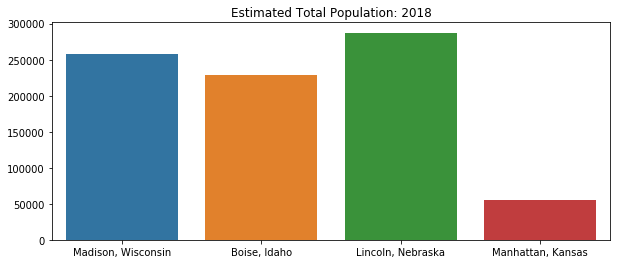

In [285]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fig, ax = plt.subplots(figsize=(10,4))
ax.set_title('Estimated Total Population: 2018')
sns.barplot(data=pop_char_data.iloc[[0]])

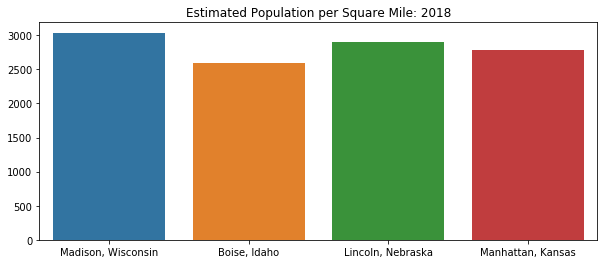

In [286]:
fig, ax = plt.subplots(figsize=(10,4))
ax.set_title('Estimated Population per Square Mile: 2018')
sns.barplot(data=pop_char_data.iloc[[1]])

##### Although Manhattan has a significantly smaller population in total, by viewing the "Estimated Population per Square mile", we can see that the population density is quite similar. Since we are measuring population density and not city geographic size, we can continue to use these cities as samples for our project.

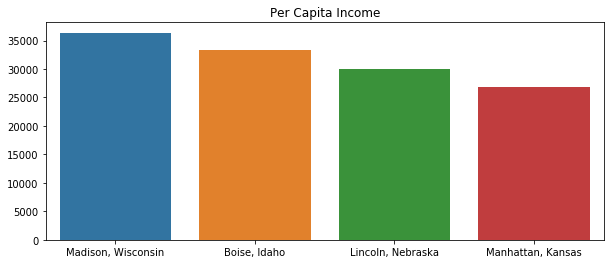

In [287]:
fig, ax = plt.subplots(figsize=(10,4))
ax.set_title('Per Capita Income')
sns.barplot(data=pop_char_data.iloc[[6]])

##### Manhattan also has a lower per capita income than the comparable cities. This will also need to be considered when developing a final conclusion.

##### Exploring age distribution between cities

In [288]:
pop_char_data.iloc[[2,3,4,5]]

,,"Madison, Wisconsin","Boise, Idaho","Lincoln, Nebraska","Manhattan, Kansas"
2,"Persons under 5 years, percent",0.052,0.058,0.066,0.048
3,"Persons under 18 years, percent",0.166,0.222,0.225,0.146
4,"Persons between 18 and under 65, percent",0.669,0.584,0.581,0.722
5,"Persons 65 years and over, percent",0.113,0.136,0.128,0.084


##### Distribution of age groups by percentage is similar. As expected, Manhattan has a larger percentage of people between 18 and under 65. This will need to be a consideration when finalizing a recommendation.

### Venue Data

#### Getting lat/long through geopy

In [289]:
# import libraries
import folium
from geopy.geocoders import Nominatim

In [290]:
# Create function that finds the latitude and longitude of each city
def latlongfinder(city):
    address = city
    geolocator = Nominatim(user_agent="Capstone")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    lat.append(latitude)
    long.append(longitude)
    print('The geograpical coordinate of {} is {}, {}.'.format(address, latitude, longitude))

In [291]:
# Create list of cities
cities = pop_char_data.columns.values[1:5]
cities = list(cities)
cities

['Madison, Wisconsin',
 'Boise, Idaho',
 'Lincoln, Nebraska',
 'Manhattan, Kansas']

In [292]:
# Find lat/long for each city and put into list
lat = []
long = []
for city in range(0,len(cities)):
    latlongfinder(cities[city])

The geograpical coordinate of Madison, Wisconsin is 43.074761, -89.3837613.
The geograpical coordinate of Boise, Idaho is 43.6166163, -116.200886.
The geograpical coordinate of Lincoln, Nebraska is 40.8088861, -96.7077751.
The geograpical coordinate of Manhattan, Kansas is 39.1836082, -96.5716694.


In [293]:
city_latlong = pd.DataFrame({'City': cities,
                            'Latitude': lat,
                            'Longitude': long})
city_latlong

,City,Latitude,Longitude
0,"Madison, Wisconsin",43.074761,-89.383761
1,"Boise, Idaho",43.616616,-116.200886
2,"Lincoln, Nebraska",40.808886,-96.707775
3,"Manhattan, Kansas",39.183608,-96.571669


#### Scraping venue information through Foursquare

In [294]:
# Set up client keys
CLIENT_ID = 'ZLTURHWLSBTGEBULQHC0UVBPWOGXUHZGXSGY2V5ZM5U0JJTC' # your Foursquare ID
CLIENT_SECRET = 'KIBCZYSPTZ53I5BDAEKCMV3DIGWIAJVS11TBOQYU1TZCM300' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

##### Select Foursquare venue categories from: https://developer.foursquare.com/docs/resources/categories

In [295]:
# List of included categories from above
categoryID = '4d4b7104d754a06370d81259,4d4b7105d754a06374d81259,4d4b7105d754a06378d81259'

In [296]:
import requests as re
import json

LIMIT = 100 #max allowable venues in free version is 100
radius = 2000

def getNearbyVenues(names, latitudes, longitudes, radius=2000):
    
    venues_list=[]
    for name, lat, lng in zip(cities, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            categoryID,
            radius, 
            LIMIT)
            
        # make the GET request
        results = re.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [297]:
# List and count venues in the four cities (limit 100 each)
city_venues = getNearbyVenues(names=city_latlong['City'],
                                   latitudes=city_latlong['Latitude'],
                                   longitudes=city_latlong['Longitude']
                                  )
# Venue count
print('Venue count is {}.'.format(city_venues.shape[0]))

Madison, Wisconsin
Boise, Idaho
Lincoln, Nebraska
Manhattan, Kansas
Venue count is 138.


In [298]:
city_venues

,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Madison, Wisconsin",43.074761,-89.383761,Madison Children's Museum,43.076790,-89.384422,Museum
1,"Madison, Wisconsin",43.074761,-89.383761,Overture Center For The Arts,43.074275,-89.387677,Performing Arts Venue
2,"Madison, Wisconsin",43.074761,-89.383761,Ivory Room Piano Bar,43.074475,-89.387225,Piano Bar
3,"Madison, Wisconsin",43.074761,-89.383761,Comedy Club on State,43.074898,-89.388055,Comedy Club
4,"Madison, Wisconsin",43.074761,-89.383761,Orpheum Theatre,43.075437,-89.388733,Indie Movie Theater
...,...,...,...,...,...,...,...
133,"Manhattan, Kansas",39.183608,-96.571669,World War II Memorial,39.187907,-96.580025,Memorial Site
134,"Manhattan, Kansas",39.183608,-96.571669,Strecker-Nelson Gallery,39.179560,-96.562255,Art Gallery
135,"Manhattan, Kansas",39.183608,-96.571669,KSU Little Theater,39.188422,-96.582158,Theater
136,"Manhattan, Kansas",39.183608,-96.571669,Purple Masque Theater,39.187771,-96.583593,Theater


In [299]:
#print('Venue count in {}: {}'.format('Madison, Wisconsin', city_venues[city_venues['City']=='Madison, Wisconsin'].shape[0])
#print('Madison venue count: 'city_venues[city_venues['City']=='Madison, Wisconsin'])
print('Madison venue count: ', city_venues[city_venues['City']=='Madison, Wisconsin'].shape[0])
print('Boise venue count: ', city_venues[city_venues['City']=='Boise, Idaho'].shape[0])
print('Manhattan venue count: ', city_venues[city_venues['City']=='Manhattan, Kansas'].shape[0])
print('Lincoln venue count: ', city_venues[city_venues['City']=='Lincoln, Nebraska'].shape[0])

Madison venue count:  44
Boise venue count:  43
Manhattan venue count:  16
Lincoln venue count:  35


##### Manhattan does not have nearly as many venues within the Arts & Entertainment, Food, and Shop & Service categories

### Maps of the four cities' venues to explore venue geographic distribution

In [300]:
# Manhattan, Kansas only locations
MK_venues = city_venues[city_venues['City']=='Manhattan, Kansas']

# Create map of Manhattan using latitude and longitude values
address = 'Manhattan, Kansas'
geolocator = Nominatim(user_agent="Manhattan_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

map_Manhattan = folium.Map(location=[latitude, longitude], zoom_start=14)

# Add markers to map
for lat, lng, city, venue, category in zip(MK_venues['Venue Latitude'], MK_venues['Venue Longitude'], MK_venues['City'], MK_venues['Venue'], MK_venues['Venue Category']):
    label = '{}, {}'.format(venue, category)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Manhattan)  
    
map_Manhattan

In [301]:
# Madison, Wisconsin only locations
MW_venues = city_venues[city_venues['City']=='Madison, Wisconsin']

# Create map of Madison using latitude and longitude values
address = 'Madison, Wisconsin'
geolocator = Nominatim(user_agent="Madison_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

map_Madison = folium.Map(location=[latitude, longitude], zoom_start=14)

# Add markers to map
for lat, lng, city, venue, category in zip(MW_venues['Venue Latitude'], MW_venues['Venue Longitude'], MW_venues['City'], MW_venues['Venue'], MW_venues['Venue Category']):
    label = '{}, {}'.format(venue, category)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Madison)  
    
map_Madison

In [302]:
# Boise, Idaho only locations
BI_venues = city_venues[city_venues['City']=='Boise, Idaho']

# Create map of Boise using latitude and longitude values
address = 'Boise, Idaho'
geolocator = Nominatim(user_agent="Boise_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

map_Boise = folium.Map(location=[latitude, longitude], zoom_start=14)

# Add markers to map
for lat, lng, city, venue, category in zip(BI_venues['Venue Latitude'], BI_venues['Venue Longitude'], BI_venues['City'], BI_venues['Venue'], BI_venues['Venue Category']):
    label = '{}, {}'.format(venue, category)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Boise)  
    
map_Boise

In [303]:
# Lincoln, Nebraska only locations
LN_venues = city_venues[city_venues['City']=='Lincoln, Nebraska']

# Create map of Overland Park using latitude and longitude values
address = 'Lincoln, Nebraska'
geolocator = Nominatim(user_agent="LN_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

map_LN = folium.Map(location=[latitude, longitude], zoom_start=14)

# Add markers to map
for lat, lng, city, venue, category in zip(LN_venues['Venue Latitude'], LN_venues['Venue Longitude'], LN_venues['City'], LN_venues['Venue'], LN_venues['Venue Category']):
    label = '{}, {}'.format(venue, category)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_LN)  
    
map_LN

## Methodology <a name="methodology"></a>

#### Now that I have data about venue categories and locations, I will now combine and categorize the city data to prepare the data for comparison

### Combine and categorize city data

#### Count of unique venue categories in each city

In [304]:
for city in range(0,len(cities)):
    this_venue = city_venues[city_venues['City']==city_latlong.iloc[city,0]]
    print('Unique category count for {}: {}'.format(cities[city], len(this_venue['Venue Category'].unique())))

Unique category count for Madison, Wisconsin: 16
Unique category count for Boise, Idaho: 17
Unique category count for Lincoln, Nebraska: 14
Unique category count for Manhattan, Kansas: 10


#### Set up dataframe with dummy variables for clustering

In [305]:
# one hot encoding
df_onehot = pd.get_dummies(city_venues[['Venue Category']], prefix="", prefix_sep="")

# add City column back to dataframe
df_onehot['City'] = city_venues['City'] 

# move City column to the first column
fixed_columns = [df_onehot.columns[-1]] + list(df_onehot.columns[:-1])
df_onehot = df_onehot[fixed_columns]

df_onehot.head()

,City,Art Gallery,Art Museum,Arts & Entertainment,Comedy Club,Concert Hall,Dance Studio,Disc Golf,History Museum,Indie Movie Theater,...,Outdoor Sculpture,Performing Arts Venue,Piano Bar,Planetarium,Public Art,Racecourse,Rock Club,Science Museum,Theater,Tour Provider
0,"Madison, Wisconsin",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Madison, Wisconsin",0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,"Madison, Wisconsin",0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,"Madison, Wisconsin",0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Madison, Wisconsin",0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [306]:
# Compare column count of unique categories to dataframe columns. Should be one more than unique category count.
if df_onehot.shape[1] - 1 ==  len(city_venues['Venue Category'].unique()):
    print('Column count checks out with {} venue categories.'.format(df_onehot.shape[1] - 1))
else:
    print('Check columns')

Column count checks out with 24 venue categories.


#### Group cities and get mean of venue frequency

In [307]:
df_ven_mean = df_onehot.groupby('City').mean().reset_index()
df_ven_mean

,City,Art Gallery,Art Museum,Arts & Entertainment,Comedy Club,Concert Hall,Dance Studio,Disc Golf,History Museum,Indie Movie Theater,...,Outdoor Sculpture,Performing Arts Venue,Piano Bar,Planetarium,Public Art,Racecourse,Rock Club,Science Museum,Theater,Tour Provider
0,"Boise, Idaho",0.186047,0.000000,0.023256,0.023256,0.023256,0.069767,0.023256,0.069767,0.000000,...,0.069767,0.069767,0.000000,0.000000,0.046512,0.000000,0.069767,0.023256,0.069767,0.023256
1,"Lincoln, Nebraska",0.257143,0.028571,0.028571,0.000000,0.085714,0.028571,0.000000,0.028571,0.000000,...,0.000000,0.000000,0.000000,0.028571,0.000000,0.000000,0.057143,0.057143,0.228571,0.000000
2,"Madison, Wisconsin",0.090909,0.045455,0.000000,0.045455,0.022727,0.045455,0.000000,0.045455,0.068182,...,0.000000,0.022727,0.022727,0.000000,0.000000,0.022727,0.045455,0.022727,0.227273,0.022727
3,"Manhattan, Kansas",0.125000,0.062500,0.000000,0.000000,0.000000,0.062500,0.000000,0.000000,0.000000,...,0.000000,0.125000,0.000000,0.000000,0.000000,0.000000,0.062500,0.062500,0.187500,0.000000


In [308]:
num_top_venues = 10

for hood in df_ven_mean['City']:
    print("----"+hood+"----")
    temp = df_ven_mean[df_ven_mean['City'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Boise, Idaho----
                   venue  freq
0            Art Gallery  0.19
1          Movie Theater  0.07
2                Theater  0.07
3              Rock Club  0.07
4  Performing Arts Venue  0.07
5      Outdoor Sculpture  0.07
6            Music Venue  0.07
7                 Museum  0.07
8         History Museum  0.07
9           Dance Studio  0.07


----Lincoln, Nebraska----
            venue  freq
0     Art Gallery  0.26
1         Theater  0.23
2    Concert Hall  0.09
3     Music Venue  0.06
4  Science Museum  0.06
5       Rock Club  0.06
6          Museum  0.06
7  History Museum  0.03
8     Planetarium  0.03
9       Jazz Club  0.03


----Madison, Wisconsin----
                 venue  freq
0          Music Venue  0.23
1              Theater  0.23
2          Art Gallery  0.09
3  Indie Movie Theater  0.07
4          Comedy Club  0.05
5         Dance Studio  0.05
6            Rock Club  0.05
7       History Museum  0.05
8           Art Museum  0.05
9       Science Museum  0.0

#### Put info into pandas dataframe and show by top venue count

In [309]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['City']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue Category'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue Category'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['City'] = df_ven_mean['City']

for ind in np.arange(df_ven_mean.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(df_ven_mean.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,City,1st Most Common Venue Category,2nd Most Common Venue Category,3rd Most Common Venue Category,4th Most Common Venue Category,5th Most Common Venue Category,6th Most Common Venue Category,7th Most Common Venue Category,8th Most Common Venue Category,9th Most Common Venue Category,10th Most Common Venue Category
0,"Boise, Idaho",Art Gallery,Performing Arts Venue,Dance Studio,History Museum,Theater,Museum,Music Venue,Outdoor Sculpture,Movie Theater,Rock Club
1,"Lincoln, Nebraska",Art Gallery,Theater,Concert Hall,Science Museum,Rock Club,Music Venue,Museum,Art Museum,Arts & Entertainment,Dance Studio
2,"Madison, Wisconsin",Theater,Music Venue,Art Gallery,Indie Movie Theater,Art Museum,Rock Club,Comedy Club,Dance Studio,History Museum,Museum
3,"Manhattan, Kansas",Theater,Movie Theater,Performing Arts Venue,Memorial Site,Art Gallery,Art Museum,Museum,Rock Club,Science Museum,Dance Studio


In [310]:
# Transpose dataframe
ven_cat_list = neighborhoods_venues_sorted.transpose()
ven_cat_list.head()

,0,1,2,3
City,"Boise, Idaho","Lincoln, Nebraska","Madison, Wisconsin","Manhattan, Kansas"
1st Most Common Venue Category,Art Gallery,Art Gallery,Theater,Theater
2nd Most Common Venue Category,Performing Arts Venue,Theater,Music Venue,Movie Theater
3rd Most Common Venue Category,Dance Studio,Concert Hall,Art Gallery,Performing Arts Venue
4th Most Common Venue Category,History Museum,Science Museum,Indie Movie Theater,Memorial Site


#### List of venue category by number of venues in each city

In [311]:
# Reset header and display full list
new_header = ven_cat_list.iloc[0]
ven_cat_list = ven_cat_list[1:]
ven_cat_list.columns = new_header
ven_cat_list

City,"Boise, Idaho","Lincoln, Nebraska","Madison, Wisconsin","Manhattan, Kansas"
1st Most Common Venue Category,Art Gallery,Art Gallery,Theater,Theater
2nd Most Common Venue Category,Performing Arts Venue,Theater,Music Venue,Movie Theater
3rd Most Common Venue Category,Dance Studio,Concert Hall,Art Gallery,Performing Arts Venue
4th Most Common Venue Category,History Museum,Science Museum,Indie Movie Theater,Memorial Site
5th Most Common Venue Category,Theater,Rock Club,Art Museum,Art Gallery
6th Most Common Venue Category,Museum,Music Venue,Rock Club,Art Museum
7th Most Common Venue Category,Music Venue,Museum,Comedy Club,Museum
8th Most Common Venue Category,Outdoor Sculpture,Art Museum,Dance Studio,Rock Club
9th Most Common Venue Category,Movie Theater,Arts & Entertainment,History Museum,Science Museum
10th Most Common Venue Category,Rock Club,Dance Studio,Museum,Dance Studio


#### Count of comparable cities that have at least one venue of each category

In [312]:
# Get list of venue categories from Manhattan
MK = list(ven_cat_list['Manhattan, Kansas'])

# Combine venue category list from comparable cities
BI = list(ven_cat_list['Boise, Idaho'])
MW = list(ven_cat_list['Madison, Wisconsin'])
LN = list(ven_cat_list['Lincoln, Nebraska'])
ven_list = BI+MW+LN

In [313]:
# Count categories of comparable cities and sort
venue_count = pd.DataFrame({'Category':ven_list})
venue_count['Count'] = venue_count.groupby('Category')['Category'].transform('count')
venue_count.sort_values(by='Count', ascending=0, inplace=True)
venue_count.drop_duplicates(subset='Category', inplace=True)
venue_count.reset_index(drop=True, inplace=True)
venue_count.head(20)

,Category,Count
0,Art Gallery,3
1,Music Venue,3
2,Museum,3
3,Rock Club,3
4,Theater,3
5,Dance Studio,3
6,History Museum,2
7,Art Museum,2
8,Movie Theater,1
9,Outdoor Sculpture,1


In [314]:
# Check to see if 'Gaming Cafe' or 'Bakery' is in any of the other cities
print('Gaming Cafe' in venue_count.Category.values)
print('Bakery' in venue_count.Category.values)

False
False


#### List of venue categories in at least one of the comparable cities but not in Manhattan

In [315]:
list(set(list(venue_count['Category'])) - set(MK))

['Outdoor Sculpture',
 'Indie Movie Theater',
 'Arts & Entertainment',
 'Comedy Club',
 'History Museum',
 'Music Venue',
 'Concert Hall']

#### List of venue categories in at least two of the comparable cities but not in Manhattan

In [316]:
venue_2 = venue_count[venue_count['Count']>1]
list(set(list(venue_2['Category'])) - set(MK))

['Music Venue', 'History Museum']

#### List of venue categories in all three of the comparable cities but not in Manhattan

In [317]:
venue_3 = venue_count[venue_count['Count']>2]
list(set(list(venue_3['Category'])) - set(MK))

['Music Venue']

#### List of venue categories in Manhattan and not in any of the other cities

In [318]:
MK_only = list(ven_cat_list['Manhattan, Kansas'])
for i in range(0,len(venue_count)):
    for y in MK_only:
        if venue_count['Category'][i] == y:
            MK_only.remove(y)
MK_only

['Memorial Site']

## Results  <a name="results"></a>

This analysis revealed several valuable insights, which will be further explored in the Discussion section:

1) Manhattan has a lower per capita income (26,777 USD) than the comparable cities (avg. 33,224 USD).

2) Manhattan's 18 - 65 year old population is a larger percentage of the total population (72.2%) than the comparable cities (61.1%) and its other age groups are all a smaller percentage.

3) Manhattan has about 1/2 to 1/3 of the venue count within the searched categories (16 versus 35, 43, and 44 venues).

4) The venue categories of "Gaming Cafe" and "Bakery" are not found in any of the searched cities.

5) "Music Venue" is in the three comparable cities, but not in Manhattan.

## Discussion <a name="discussion"></a>

In order to explore if there is an opening in the market for a board games and baked goods amusement center in Manhattan, I needed to **first: determine if there is a consumer base for that kind of venue**, and **second: explore if that consumer base already has sufficient supply to satisfy its demand**.

Being largely a college city, is no surprise that Manhattan, Kansas has a lower per capita income *(Result #1)* and a larger 18-65 age group percentage *(Result #2)*. A lower per capita income often means a lower amount of disposable income that can be spent on entertainment. And since this age group is a larger percentage than the comparable cities, a good business plan would make preparations to either target that market group despite the obstacles or focus its full efforts on the disproportionately small percentage of other age groups.

Manhattan may have an 11% smaller proportion of non-18-to-65 year age groups, but it also offers less than half the family friendly venue options *(Result #3: 16 venues compared to an average of 41)*. This vacuum of family friendly venues could easily more than make up for the 11% reduction in the stereotypical market if the venue management chooses to ignore the 18-65 crowd.

The venue categories of “Gaming Café” and "Bakery" are not in any of the comparable cities *(Result #4)*. That could either mean that there is no demand, or there is simply no supply for those genres. Research will need to be done to find out which one it is (in Manhattan, at least). 

One last insight is that at least one “Music Venue” location exists in the three comparable cities but not in Manhattan *(Result #5)*. This seems to be an opportunity where other cities have seen demand but Manhattan has not supplied.

## Conclusion <a name="conclusion"></a>

Based on the results of this analysis, I conclude that **there is opportunity for a venue such as a board games amusement center that serves fresh baked goods and other treats**.

There is risk that neither venue category exists in any of the comparable cities, but some local market research could determine if there is demand for either and, if so, my friend will have the only location.

She will also need to decide if she wants to ignore or cater to the college student market. Typical college students can afford simple pleasures such as coffee and other baked goods and board games are a fun social activity for young adults. So they are a good market for these activities if they are looking for an alternative to the drinking night life. She will need to be strategic in how she designs and schedules activities because relying entirely on college students or ignoring them in favor of catering to children and families is a missed opportunity. If she can make an environment that is welcoming to both or schedules activities (such as adult board game tournaments after 8PM), she could take advantage of both markets.

Noting that “Music Venue” is in all three other comparable cities but not in Manhattan seems like an opportunity. Baked goods often go well with music, but board games often need communication and concentration (which could be difficult with a live band). Perhaps the night schedule could alternate between live music on select nights only and board game tournaments on others.

**I believe a venue of the proposed type could be successful in Manhattan, Kansas.**